In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")

In [51]:
from tokenizers import Tokenizer
import sys

import matplotlib.pyplot as plt
import numpy as np
import collections
import torch

from ChEmbed.data import chembldb, smiles_dataset, chembed_tokenize
from ChEmbed.training import trainer
from ChEmbed.modules import simple_rnn
import attr

from ChEmbed import plots, utilities

from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [52]:
chembl_raw = chembldb.ChemblDB()
chembl_smiles = chembl_raw._load_or_download()["canonical_smiles"]

In [53]:
tokenizer = chembed_tokenize.load_chembed_tokenizer(filepath = "../data/tokenizers/tokenizer-chembldb-16-06-2025.json")

In [54]:
# chembl_dataset = smiles_dataset.SMILESDataset(
#     smiles_list = chembl_smiles,
#     tokenizer = tokenizer
# )

# chembl_mini = smiles_dataset.SMILESDataset(
#     smiles_list = chembl_smiles[:5000],
#     tokenizer = tokenizer
# )

In [82]:
chembl_mini = smiles_dataset.SMILESDatasetContinuous(
    smiles_list = chembl_smiles[:10000],
    tokenizer = tokenizer,
    length = 1024,
)

In [83]:
chembl_mini[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [84]:
model = simple_rnn.simpleRNN(
    # Mandatory
    num_hiddens = 128,
    vocab_size = len(tokenizer),
    # tuning
    learning_rate = 0.05,
    weight_decay = 0.02
)

In [85]:
model.initialize_parameters(model)

In [86]:
def predict(input, num_preds, model, dataset, device=None):
    state, outputs = None, [input[0]]

    # predict input + num_preds tokens
    for i in range(len(input) + num_preds - 1):
        
        X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)
        
        rnn_outputs, state = model.rnn(X, state)

        if i < len(input) - 1:
            outputs.append(input[i + 1])
        else:
            tokens = model.linear(rnn_outputs).argmax().tolist()
            Y = dataset.tokenizer.decode(tokens)
            outputs.append(Y)

    return ''.join(outputs)
            

In [87]:
print(predict("CCC", 30, model, chembl_mini, device="cpu"))

/tmp/ipykernel_56562/2808148441.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


CCCcc4FCCc1cc############################


In [88]:
model_trainer = trainer.Trainer(max_epochs=32, init_random=None, clip_grads_norm=0.2)
model_trainer.fit(model, chembl_mini)

Epoch 1/32: Train Loss: 4.1918, Val Loss: 4.1802
Epoch 2/32: Train Loss: 3.8706, Val Loss: 2.2785
Epoch 3/32: Train Loss: 3.3956, Val Loss: 2.4007
Epoch 4/32: Train Loss: 2.9548, Val Loss: 3.2488
Epoch 5/32: Train Loss: 2.8491, Val Loss: 1.9416
Epoch 6/32: Train Loss: 1.8738, Val Loss: 2.0217
Epoch 7/32: Train Loss: 2.0749, Val Loss: 1.9638
Epoch 8/32: Train Loss: 1.8977, Val Loss: 1.9691
Epoch 9/32: Train Loss: 2.2292, Val Loss: 2.7157
Epoch 10/32: Train Loss: 2.5679, Val Loss: 1.7937
Epoch 11/32: Train Loss: 1.5282, Val Loss: 1.5117
Epoch 12/32: Train Loss: 1.9947, Val Loss: 2.9935
Epoch 13/32: Train Loss: 2.7694, Val Loss: 2.0335
Epoch 14/32: Train Loss: 1.9143, Val Loss: 1.8803
Epoch 15/32: Train Loss: 1.9724, Val Loss: 1.9567
Epoch 16/32: Train Loss: 1.8457, Val Loss: 1.8528
Epoch 17/32: Train Loss: 2.0717, Val Loss: 2.3456
Epoch 18/32: Train Loss: 2.1589, Val Loss: 1.5958
Epoch 19/32: Train Loss: 1.4885, Val Loss: 1.6241
Epoch 20/32: Train Loss: 1.8985, Val Loss: 2.2680
Epoch 21/

In [92]:
print(predict("C=", 30, model, chembl_mini, device="cuda"))

C=HHHHHHHHHHHHHHH


/tmp/ipykernel_56562/2808148441.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


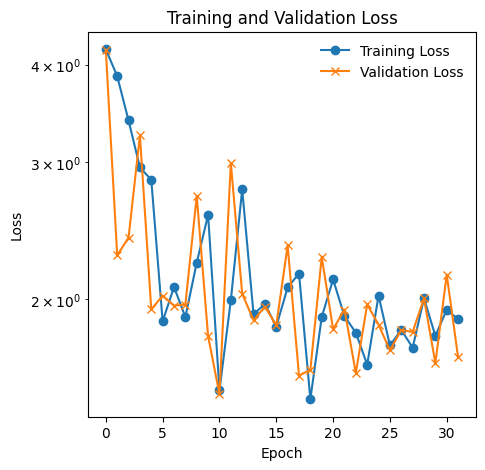

In [93]:
losses = utilities.extract_training_losses(model_trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')